## 《計算機程式期末報告》

#### 一、組員名單:

1. 106207411 財管三   文永慷

2. 106307031 地三土測 李睿莆

3. 105207445 地四土測 柯騰達

4. 105701051 應數四   黃健瑋


#### 二、組員分工表:

1. 106207411 財管三 文永慷 / 
閱讀相關文獻、影片處理、資料蒐集

2. 106307031 地三土測 李睿莆 / 
閱讀相關文獻、資料處理、建立模型、測試與修改資料

3. 105207445 地四土測 柯騰達 / 
閱讀相關文獻、資料處理、建立模型、測試與修改資料

4. 105701051 應數四 黃健瑋 / 
閱讀相關文獻、資料蒐集、測試與修改資料

#### 三、問題發想與動機:

* 想嘗試建立不動產自動估價模型的原因為，現行房市資訊不透明，導致價格的決定權往往掌握在建商手裡，消費者只能以建商公布的價格做為參考依據。但應該需要有一個能夠公正推估房屋價格的方式供消費者使用，否則消費者只能夠從建商端知道房價，根本沒有與建商議價的能力，自動估價模型的建立即可滿足上述需求，提供民眾一個真實且可靠的參考價格，透過政府發佈的房地產買賣實價登錄資料建立模型，改善傳統人力估價高人力且時間成本的問題，且同時排除了人為估價可能衍生的人為主觀因素，並貫徹「用機器去處理，讓資料本身變成一個合理、乾淨、不會產生偏誤的情況」的概念，將來若是可將準確度及誤差進一步修正，即可提供民眾買房時一個客觀且公正的參考指標，將有助於遏止現行不動產市場可能出現的惡意炒價或是虛報價格的問題，是一個非常值得長久且持續研究的題目。

#### 四、資料來源與解釋:

* 兩年來政府部門之實價登錄資料(資料日期涵蓋2018到2019年)

### 輸入資料(模型變數選擇)
* 數值型變數: 移轉總面積（土地、建物）、交易筆棟數（土地、建物、車位）、移轉層次、總樓層數、建物現況格局（房、衛、廳、隔間）、標的座標（X、Y）、標的經緯度、屋齡

* 虛擬變數（Dummy Variable）: 建物使用分區（住、工、商、其他）、主要建材（8種）、主要用途（住家用、住商用、工業用、商業用）、建物型態（公寓、住宅大樓、華廈、套房）、有無管理單位、有無車位、車位種類（8種）



### 輸出資料
* 不動產單價(元/平方公尺)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from ipywidgets import interact_manual

# A. 資料前處理
## 1. 不動產實價登錄資料篩選
* 因透天厝的 AVM 是利用買賣房屋的總價建模，其餘建物型態則是需使用單價建模，故此次報告並不會將透天厝的資料也一起拿來訓練
* 建物型態:公寓、住宅大樓、華廈、套房
* 交易標的:土地+建物、土地+建物+車位

In [2]:
gpd_df_house = pd.read_csv('raw_houses.csv')
gpd_df_house = gpd_df_house.fillna("")
gpd_df_house = gpd_df_house[((gpd_df_house['建物型態']=='公寓(5樓含以下無電梯)') | (gpd_df_house['建物型態']=='住宅大樓(11層含以上有電梯)') | (gpd_df_house['建物型態']=='華廈(10層含以下有電梯)') | (gpd_df_house['建物型態']=='套房(1房1廳1衛)'))]
gpd_df_house = gpd_df_house[((gpd_df_house['交易標的']=='房地(土地+建物)')|(gpd_df_house['交易標的']=='房地(土地+建物)+車位'))]
gpd_df_house = gpd_df_house[(gpd_df_house['county']=='台北市')]

c:\users\owner\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. 不動產實價登錄資料清理
  * Step 1
  
    因實價登錄資料中會留有一些特殊態樣的交易資料，例如:親友間交易、瑕疵屋交易、毛胚屋交易等等，這些特殊態樣交易型態的交易價格其實是非常異於市場行情的，因此在建立模型前應該透過實價登錄資料備註欄提供的資訊，將這些特殊態樣的交易資料清除，才不會使模型預測的價格偏離真實市場成交價格，下方羅列出57種特殊態樣的交易型態，皆為建立模型前須清除的交易資料


In [3]:
def boolean_based_on_note(df, a1s, a0s, a11s):
    boolean_selected = pd.Series(np.array([False]*df.shape[0]))
    for a1 in a1s:        
        boolean_selected = (boolean_selected | df['備註'].str.contains(a1, na=False))  #包含此文字內容會進入備註欄==true
        
    for a0 in a0s:
        boolean_selected = (boolean_selected & ~df['備註'].str.contains(a0, na=False)) #包含此文字不會進入備註欄==false
        
    for a11 in a11s:
        boolean_selected = (boolean_selected | df['備註'].str.contains(a11, na=False))   #包含此文字內容會進入備註欄==true
        
    return boolean_selected

In [4]:
def set_note_flag(df, flag_name, a1s, a0s, a11s):
    df[flag_name] = False
    df.loc[boolean_based_on_note(df, a1s, a0s, a11s), flag_name] = True

In [5]:
set_note_flag(gpd_df_house, "flag_毛胚屋", 
            ['無.*隔間','毛胚','房間需自行隔間','未隔間'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_瑕疵物件", 
            ['瑕疵物件','海砂屋','受損房屋','老舊','凶宅','祭祀公業','事故','非自然','無接水電','損壞','破損','滲*水','壁癌','屋況不佳','屋況.*差','屋況嚴重瑕疵','房屋.*半毀','房屋破舊','屋況需整理','屋況殘破','屋況不良','房屋.*已坍塌','房屋老舊','建物須整修','部分土地有人死亡','入口處狹小巷弄狹小','無接水接電','高壓電線正下方','多年無人使用','建物已毀損','死亡','事故','年久失修','廢墟','無法居住','面積流失','荒廢','河床侵蝕'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_公共設施保留地", 
            ['公共設施保留地','公設','公保地','公共設施用地','道路用地','溝渠','學校用地'], 
            ['獨立產權公設','車位併入公設','因公共設施.*與土地所有權人協議價購之案件','公設車位','非道路用地','臨近.*溝渠'], 
            [])

set_note_flag(gpd_df_house, "flag_含地上物之土地", 
            ['定著物','地上物','地下物','農作物','工作物','出產物','天然孳息','天然資源','地上農作物','器具','樹','含地上建物','貨櫃屋','地上.*鐵皮屋','含鐵皮屋','地上建物.*未保存登記'], 
            ['不含地上物'], 
            [])

set_note_flag(gpd_df_house, "flag_向政府機關承購", 
            ['承購','水利會','台糖','市府地讓售','跟政府機構購買','國有土地申購','向國防部價購','向國防部標購','公有地'], 
            ['共有土地承購','水利會協議價購私有土地','水利會價購','水利會協議價購民眾土地'], 
            [])

set_note_flag(gpd_df_house, "flag_含增建或未登記建物", 
            ['增建','未.*登記','未.*保存','無保存','未辦保登','無登記','加蓋','外推','加建','外移','頂加','鐵皮屋','鐵皮厝','增建.*農業資材室','增建.*儲藏室'], 
            ['不包括.*增建','不包括.*未登記','不含.*未登記','未包含.*未保存','無增建','未分割','未.*繼承','補辦登記','未辦理過戶登記','未辦移轉','祖產未登記','未移轉登記','未償債務','不包含未保存','不含未登記','分次登記','未包含在本次土地買賣價金內','地上.*鐵皮屋','含鐵皮屋','未保存建物占用','鄰地.*增建','車位.*面積未登記','尚未成立管委會','抵償','建物.*不計價','不計入價金','未計算價金','未計入土地交易總價中','未辦簽約僅辦理登記','未辦登記僅辦簽約','僅.*產權移轉登記','代理辦理登記','地政士.*並未代理撰擬不動產買賣契約書','無登記在書狀內','不另計價','增建不計價','附贈.*增建','贈與未登記建物','加蓋為0','未辦之借名登記','未登記建物所有權人購買土地','地上未登記建物為買方所有','稅金問題遲未登記','僅受託買賣案件申請登記','增建部分占用國產署土地','未拆分單價'], 
            ['未辦保存登記及未辦繼承登記','繼承後','未保存建物'])

set_note_flag(gpd_df_house, "flag_親友、員工或其他特殊關係", 
            ['親友','朋友','親屬','親戚','近親','員工','特殊關係','關係戶','親等','等親','朋友關係','兄','弟','姐','姊','妹','叔','姪','母','父','女','子','祖','孫','女兒','直系血親','股東','好友','姑','關係人','關係企業','伯','媳','同事','夫','妻','嫂','監察人','董事','婆媳','鄰居間交易','鄰居關係','信徒與寺廟','信徒與宮廟','配偶','姻親','熟人','房東.*房客','承租戶購買','承租戶承買','公益交易','特惠戶','買方為地上房屋所有權人','合夥關係','地主戶'], 
            ['車位','子母車位','股東股權讓渡','九份子'], 
            [])

set_note_flag(gpd_df_house, "flag_單獨車位", 
            ['單獨車位交易','車位買賣','停車塔','機車車位','買賣土地為停車位','車位移轉','單獨出賣.*車位','僅為車位權利範圍移轉','停車位加購','本案僅車位買賣','只買停車位'], 
            ['內含獨立產權車位','含.*車位','含機車.*位','內含機車位','有機車位','有車位','未各別拆算單一停車位價格','無法拆分','無拆分','無法拆分車位面積','無法拆算','車位拆價','含車位款','車位.*元'], 
            [])

set_note_flag(gpd_df_house, "flag_債權債務影響或債務抵償", 
            ['清償','抵償','借','貸','債權','債務','讓與','拍賣','金拍','銀拍','抵押權','攔拍取得'], 
            ['清償.*費'], 
            [])

set_note_flag(gpd_df_house, "flag_畸零地或有合併使用", 
            ['畸零地','崎零地','合併','毗鄰地','毗鄰業主購買','地形調整','地形不整','土地四散','毗鄰界址調整交換分割合併','毗連界址調整交換分割合併'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_協議價購", 
            ['協議價購','協購','政府價購','整體開發案價購','交通用地.*價購','一併價購'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_占用相關", 
            ['佔用','占用','鑑界','鄰地界指糾葛','占有人','越界','鄰地佔有','房屋現況占鄰地','界址調整','小面積佔有協調','地界線'], 
            ['第三人[佔占][用有]|他人[佔占][用有]|第三人房屋|他人房屋'], 
            [])

set_note_flag(gpd_df_house, "flag_被他人佔用", 
            ['第三人[佔占][用有]|他人[佔占][用有]|第三人房屋|他人房屋'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_急買急賣", 
            ['急買','急賣','賣方急錢用','急售','急換屋需資金','急著出售','急出售'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_共有及持分", 
            ['共有人.*買賣','土地法34-1','共有人標售','共有人.*交易','共有人承買','共有人承售','持分','共有人買回','民法物權編施行8-5條第3項','共有土地承購','共有物分割後之分割買賣交換合併','產權複雜','共有物買賣','共有人優先承買','共有土地買賣','簡化共有關係'], 
            ['持分建物','\d持分','持分\d','持分調整','整理土地持分','持分共有','共有人數','持分土地','土地產權持分','共有人無人應買'], 
            [])

set_note_flag(gpd_df_house, "flag_所有權人返還", 
            ['所有權人返還','借名登記','借名登記返還','返還所有權'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_總價包含費用", 
            ['修繕','翻修','有整修','材料變更','管理費','屋況.*翻新','管線*換新','含房屋裝修','屋況有整理過','有裝修','買方補償','全新整理'], 
            ['賣方.*修繕','不負.*修繕責任','自行修繕'], 
            [])

set_note_flag(gpd_df_house, "flag_價格低於場行情", 
            ['公告現值','公告地價','低於市價','賤賣','售價偏低','低於公告市值','產權只移轉一半','優惠','減價','部分價款免除支付','折讓','半買半贈','半捐贈','車位贈送不計價','部份價金免除','特惠價','社區住戶加購價','多戶議價(團購)','團購價','特惠戶','交易總價包含容積移轉價款','照顧住宅','餘戶價售','區段徵收專案配售','總價偏低.*重劃後評定地價及重劃開支狀況訂定標售價格'], 
            ['客戶要求買賣價金減價，經雙方協議後同意買賣價金不變'], 
            [])

set_note_flag(gpd_df_house, "flag_有民情風俗因素", 
            ['民情風俗因素','寺廟','供廟埕使用','路沖','宮廟'], 
            ['信徒與寺廟間之買賣','信徒與宮廟間之買賣'], 
            [])

set_note_flag(gpd_df_house, "flag_包含權利", 
            ['耕作權','通行權','優先承租權','國有地使用權'], 
            ['無出入通行權'], 
            [])

set_note_flag(gpd_df_house, "flag_未臨路或其餘臨路相關", 
            ['無路','無出路','無出口','無產業道路','無聯外','無連外','無適宜連外','未面臨道路','無面臨馬路','未臨道路','未瀕臨巷道','臨路','沒有路','無.*道路','裡地','袋地','道路中斷','車輛無法到達','徒步','死巷','聯外需經他人土地','無通路','無臨接道路'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_土地使用受限", 
            ['無法開墾','農路使用','河川','斷層','地質敏感','不易建築','林業區','無意使用','陡','地形歪斜','行水區','不利使用','山坡地保育區','地形崎嶇','無法指定建築線及申請建照','大部分土地沒入河道中','保護區雜木林地'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_鄰地相關", 
            ['臨地所有權人購買','鄰地'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_國家機關 國有土地之買賣價格正向影響", 
            ['國產署','國有財產署','財產署','國產局','標售','向國產署標購','國有財產承購','市府讓售'], 
            ['共有人標售','地籍清理.*標售'], 
            [])

set_note_flag(gpd_df_house, "flag_國家機關 國有土地之買賣價格負向影響", 
            ['地籍清理','地籍清理.*標售','地清土地','土地清理','祭祀公業'], 
            ['部分土地係向祭祀公業承租'], 
            [])

set_note_flag(gpd_df_house, "flag_建物含電梯", 
            ['電梯','公寓.*電梯','電梯公寓','有裝設電梯'], 
            ['無電梯'], 
            [])

set_note_flag(gpd_df_house, "flag_其他 價格正向影響", 
            ['高價購買','抵費地','抵價地'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_其他 價格負向影響", 
            ['地主回購建物','原住名保留地','偏遠','裝修工程款','角地','不動產作價稱資','解除契約','原承租戶','法院調解','工程款減','整批收購','登記簿註記地籍圖計算之面積與登記面積不符','法定空地','分割買賣','分割補償','相互交換','買地送屋','包含未完成建物','部分土地係向祭祀公業承租','拉皮屋','細部計畫尚未完成.*區段徵收整體開發','政府合作開發','車位無產權','買賣標的現有他人占有使用中'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_未辦理繼承登記", 
            ['未辦.*繼承','祖產未登記'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_含有租約", 
            ['租'], 
            ['優先承租權','承租戶','承租人','租客承買','三七五租約','375租約','佃農'], 
            [])

set_note_flag(gpd_df_house, "flag_建商與地主之合建案", 
            ['合建','土地共同開發關係'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_持分建物", 
            ['持分建物'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_包含須注意之增建", 
            ['雨遮','雨棚','頂樓','陽台','陽臺','天井','露台','露臺','窗台','凸窗','夾層','防火巷','花台','採光罩','鐵棚'], 
            ['雨遮.*不予計價','雨遮.*不計價'], 
            [])

set_note_flag(gpd_df_house, "flag_混合使用", 
            ['住商混合','營業店面.*住家','工商綜合','店鋪+住宅','一樓.*店面','一樓.*店鋪','1樓.*店面','1樓.*店鋪'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_預售", 
            ['預售'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_買回", 
            ['買回','原屋主購回'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_其他 不影響價格因素", 
            ['旅舍','旅館','攤位','商場舖位','店鋪','倉儲','診所','地下室','工作室','管理組織','管委會','機房','買方另行指定登記名義人','連件辦理','保留戶','信託財產'], 
            ['另有一儲藏室'], 
            [])

set_note_flag(gpd_df_house, "flag_塔位或墓園", 
            ['塔位','墓園','公墓','墳'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_地上權", 
            ['地上權'], 
            ['土地為地上權一部讓與'], 
            [])

set_note_flag(gpd_df_house, "flag_內含獨立產權公設", 
            ['獨立產權公設','獨立產權車位','車位併入公設','公設車位'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_內含獨立產權公設", 
            ['獨立產權公設','獨立產權車位','車位併入公設','公設車位'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_樣品屋或裝潢", 
            ['裝潢','裝璜','實品屋','樣品屋'], 
            ['重新.*裝潢','翻修裝潢','重新.*裝璜','翻修裝璜'], 
            [])

set_note_flag(gpd_df_house, "flag_建物包含地下室", 
            ['地下室'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_其他稅、費相關", 
            ['稅','其他費用','整地費','仲介費','賣清','買清'], 
            ['抵償'], 
            [])

set_note_flag(gpd_df_house, "flag_多戶打通", 
            ['打通'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_現況點交", 
            ['點交','傢俱','家具','傢具','設備','沙發','電視','床組','冰箱','餐桌','洗衣機','冷氣','現況交付','現況交屋'], 
            ['無.*設備','不含.*設備','不點交'], 
            [])

set_note_flag(gpd_df_house, "flag_都市計畫農業區建地目土地", 
            ['建地目','地目:建'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_訴訟相關", 
            ['訴訟買賣案件','法院調解買賣','法院和解','調解購置','訴訟和解','調解買賣'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_耕地三七五", 
            ['三七五租約','佃農','375租約'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_建物不計價", 
            ['建物不計價'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_車位輪抽", 
            ['車位.*抽籤','車位.*輪抽','抽籤.*車位','定期抽籤'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_只買建物", 
            ['仁愛之家','土地是仁愛之家所有'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_土地及建物分次登記案件", 
            ['分.*次.*登記','土地建物分開登記'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_重劃區土地", 
            ['重劃區','土地重劃','區段徵收整體開發'], 
            ['重劃區抵費地','細部計畫尚未完成.*區段徵收整體開發'], 
            [])

set_note_flag(gpd_df_house, "flag_農舍", 
            ['農舍'], 
            ['不計價','非農舍'], 
            [])

set_note_flag(gpd_df_house, "flag_私設巷道、道路、通道", 
            ['私設道路','私設巷道','私設通道','出入口使用'], 
            [], 
            [])

set_note_flag(gpd_df_house, "flag_土地作其他使用", 
            ['道路用','道路使用','路地','通行使用','既成道路','現況為道路','既成道路','既成巷道','通道','減災工程','高壓鐵塔用地','通行需要','鐵路用地','電塔用地','水利用地','國土保安用地','園道'], 
            ['鄰地鐵路管理局管理鐵路用地優先承租權'], 
            [])

c:\users\owner\appdata\local\programs\python\python36\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [6]:
gpd_df_house.to_excel('filter_taipei.xlsx')

* Step 2 

  離群值剔除(因為在做房價模型預測時過高或過低的成交價格，Outlier會導致整個模型產生偏移的情形，故根據下方直方圖可以看出離群值大部分聚集在分布的前2.5%及後2.5%，需將該資料清除後才可進模型進行訓練)
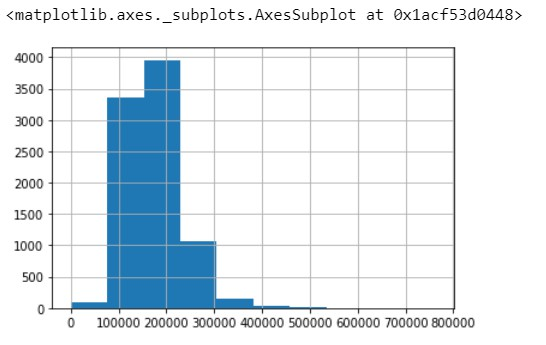

## 3. 接下來的資料處理部分在EXCEL中進行處理，分述如下:
* 刪除不必要欄位
* 確認是否有空值
* 檢查實價登陸備註欄
* 將部分欄位資料轉為虛擬變數(Dummy Variables)
* 對部分欄位資料進行正規化處理

# B. 建置模型準備

### 讀入處理後之資料

In [26]:
x_data = pd.read_excel('correct_data_x.xlsx')

In [27]:
y_data = pd.read_excel('correct_data_y.xlsx')

### 檢視處理後之資料

In [28]:
print("x_data",x_data)
print("y_data",y_data)

x_data       土地移轉總面積(平方公尺)  工  住  商  其他  交易筆棟數_土地  交易筆棟數_建物  交易筆棟數_車位      移轉層次  \
0          0.062492  0  1  0   0  0.035714       0.0  0.166667  0.222222   
1          0.050186  0  1  0   0  0.071429       0.0  0.083333  0.305556   
2          0.044306  0  1  0   0  0.035714       0.0  0.083333  0.194444   
3          0.061529  0  0  1   0  0.035714       0.0  0.000000  0.333333   
4          0.030439  0  0  1   0  0.035714       0.0  0.000000  0.194444   
...             ... .. .. ..  ..       ...       ...       ...       ...   
8243       0.198272  0  1  0   0  0.035714       0.0  0.083333  0.138889   
8244       0.055884  0  0  1   0  0.071429       0.0  0.083333  0.527778   
8245       0.005854  0  0  1   0  0.035714       0.0  0.000000  0.416667   
8246       0.169420  0  1  0   0  0.071429       0.0  0.083333  0.444444   
8247       0.036189  0  0  1   0  0.071429       0.0  0.083333  0.416667   

          總樓層數  ...  其他.1  坡道平面  坡道機械  塔式車位  空格   交易標的橫坐標   交易標的縱坐標        屋齡  \

### 將資料分成訓練集(佔資料集75%)、測試集(佔資料集25%)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=0)

### 檢視訓練資料、測試資料
* X_train 共 6186 筆資料，包含 46 種變數
* y_train 共 6186 筆資料，單位為單價(元/平方公尺)
* X_test 共 2062 筆資料，包含 46 種變數
* y_test 共 2062 筆資料，單位為單價(元/平方公尺)

In [30]:
print("X_train",X_train)
print("y_train",y_train)
print("X_test",X_test)
print("y_test",y_test)

X_train       土地移轉總面積(平方公尺)  工  住  商  其他  交易筆棟數_土地  交易筆棟數_建物  交易筆棟數_車位      移轉層次  \
8124       0.078570  0  0  1   0  0.035714       0.0  0.166667  0.222222   
5598       0.042407  0  1  0   0  0.071429       0.0  0.083333  0.222222   
7955       0.148034  0  1  0   0  0.035714       0.0  0.083333  0.222222   
322        0.027786  0  0  1   0  0.035714       0.0  0.000000  0.361111   
7476       0.073731  0  1  0   0  0.035714       0.0  0.000000  0.277778   
...             ... .. .. ..  ..       ...       ...       ...       ...   
4373       0.109010  0  1  0   0  0.035714       0.0  0.000000  0.277778   
7891       0.040534  0  0  1   0  0.035714       0.0  0.000000  0.305556   
4859       0.105263  0  1  0   0  0.035714       0.0  0.083333  0.388889   
3264       0.098733  0  1  0   0  0.035714       0.0  0.166667  0.277778   
2732       0.082525  0  1  0   0  0.035714       0.0  0.083333  0.333333   

          總樓層數  ...  其他.1  坡道平面  坡道機械  塔式車位  空格   交易標的橫坐標   交易標的縱坐標        屋齡  

In [31]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

### 建置不動產估價模型AVM(Automatic Valuation Models)
* 隱藏層數 = 2
* 激活函數 = LeakyReLU(alpha=0.22)
* Dropout 層 = 1
* 損失函數 = MAPE
* 優化器 = ADAM
* 在第一個隱藏層與激活函數間建立BN層(BatchNormalization)

In [41]:
model = Sequential()

model.add(Dense(512,input_dim=46))
# model.add(BatchNormalization())
model.add(Activation(tf.keras.layers.LeakyReLU(alpha=0.22)))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation(tf.keras.layers.LeakyReLU(alpha=0.22)))
model.add(Dropout(0.175))
# model.add(Dense(128))
# model.add(BatchNormalization())
# model.add(Activation(tf.keras.layers.LeakyReLU(alpha=0.22)))
# model.add(Dropout(0.235))
model.add(Dense(64))
# model.add(BatchNormalization())
model.add(Activation(tf.keras.layers.LeakyReLU(alpha=0.22)))
model.add(Dense(1,activation=tf.keras.layers.LeakyReLU(alpha=0.22)))
model.compile(loss='mean_absolute_percentage_error',optimizer='Adam')

### 檢視模型

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               24064     
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

### 為了避免繼續訓練模型會導致測試集上的準確率下降(或是說loss上升)，我們引入了EarlyStopping提前停止訓練，當驗證集loss的減少程度不再下降時則停止繼續訓練

* monitor設為'val_loss'，用以監控驗證集的loss
* patience設為70，若經過70次epochs後驗證集的loss不再顯著下降，則提前停止訓練

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 70, verbose = 1, mode = 'auto') 

### 將訓練集27.5%分割為驗證集，開始訓練模型

In [44]:
history = model.fit(X_train,y_train,batch_size=256,epochs=700,validation_split = 0.275,callbacks = [early_stopping])

Epoch 1/700
18/18 [==============================] - 0s 18ms/step - loss: 99.9964 - val_loss: 99.9990
Epoch 2/700
18/18 [==============================] - 0s 12ms/step - loss: 99.9885 - val_loss: 99.9973
Epoch 3/700
18/18 [==============================] - 0s 11ms/step - loss: 99.9755 - val_loss: 99.9947
Epoch 4/700
18/18 [==============================] - 0s 11ms/step - loss: 99.9543 - val_loss: 99.9834
Epoch 5/700
18/18 [==============================] - 0s 11ms/step - loss: 99.9232 - val_loss: 99.9639
Epoch 6/700
18/18 [==============================] - 0s 10ms/step - loss: 99.8818 - val_loss: 99.9285
Epoch 7/700
18/18 [==============================] - 0s 13ms/step - loss: 99.8269 - val_loss: 99.8809
Epoch 8/700
18/18 [==============================] - 0s 12ms/step - loss: 99.7577 - val_loss: 99.8165
Epoch 9/700
18/18 [==============================] - 0s 11ms/step - loss: 99.6703 - val_loss: 99.6822
Epoch 10/700
18/18 [==============================] - 0s 10ms/step - loss: 99.5548

18/18 [==============================] - 0s 12ms/step - loss: 12.8998 - val_loss: 14.4038
Epoch 161/700
18/18 [==============================] - 0s 14ms/step - loss: 12.7693 - val_loss: 14.4208
Epoch 162/700
18/18 [==============================] - 0s 11ms/step - loss: 12.8449 - val_loss: 14.6459
Epoch 163/700
18/18 [==============================] - 0s 10ms/step - loss: 12.8935 - val_loss: 14.0245
Epoch 164/700
18/18 [==============================] - 0s 11ms/step - loss: 12.6955 - val_loss: 14.1327
Epoch 165/700
18/18 [==============================] - 0s 12ms/step - loss: 12.7864 - val_loss: 14.4908
Epoch 166/700
18/18 [==============================] - 0s 11ms/step - loss: 12.5410 - val_loss: 14.2609
Epoch 167/700
18/18 [==============================] - 0s 10ms/step - loss: 12.6030 - val_loss: 14.3568
Epoch 168/700
18/18 [==============================] - 0s 10ms/step - loss: 12.4986 - val_loss: 14.1090
Epoch 169/700
18/18 [==============================] - 0s 10ms/step - loss: 12

18/18 [==============================] - 0s 10ms/step - loss: 11.4394 - val_loss: 13.6475
Epoch 240/700
18/18 [==============================] - 0s 13ms/step - loss: 11.4988 - val_loss: 13.6295
Epoch 241/700
18/18 [==============================] - 0s 21ms/step - loss: 11.8771 - val_loss: 13.9479
Epoch 242/700
18/18 [==============================] - 0s 14ms/step - loss: 11.7208 - val_loss: 13.6592
Epoch 243/700
18/18 [==============================] - 0s 14ms/step - loss: 11.3756 - val_loss: 14.1535
Epoch 244/700
18/18 [==============================] - 0s 11ms/step - loss: 11.5355 - val_loss: 14.4371
Epoch 245/700
18/18 [==============================] - 0s 11ms/step - loss: 11.6260 - val_loss: 13.8484
Epoch 246/700
18/18 [==============================] - 0s 10ms/step - loss: 11.3203 - val_loss: 14.2361
Epoch 247/700
18/18 [==============================] - 0s 9ms/step - loss: 11.3732 - val_loss: 13.6342
Epoch 248/700
18/18 [==============================] - 0s 11ms/step - loss: 11.

Epoch 318/700
18/18 [==============================] - 0s 10ms/step - loss: 11.0553 - val_loss: 15.2525
Epoch 319/700
18/18 [==============================] - 0s 10ms/step - loss: 10.9802 - val_loss: 13.6840
Epoch 320/700
18/18 [==============================] - 0s 12ms/step - loss: 10.7282 - val_loss: 14.8435
Epoch 321/700
18/18 [==============================] - 0s 11ms/step - loss: 10.6515 - val_loss: 13.5981
Epoch 322/700
18/18 [==============================] - 0s 11ms/step - loss: 10.8635 - val_loss: 14.1714
Epoch 323/700
18/18 [==============================] - 0s 12ms/step - loss: 10.7642 - val_loss: 13.6649
Epoch 324/700
18/18 [==============================] - 0s 13ms/step - loss: 10.6397 - val_loss: 14.1881
Epoch 325/700
18/18 [==============================] - 0s 12ms/step - loss: 10.8879 - val_loss: 13.7185
Epoch 326/700
18/18 [==============================] - 0s 10ms/step - loss: 10.8043 - val_loss: 14.1735
Epoch 327/700
18/18 [==============================] - 0s 11ms/s

### 以模型預測測試集

In [45]:
result = model.predict(X_test)
len(result)

2062

## MAPE : 
* AVM模型測試標準通常以平均絕對誤差百分比（MAPE）及命中率（Hit Rate）這兩項作為判定模型好壞的評估指標。

* MAPE為大量不動產估價之平均誤差值，計算方式為衡量估計值與實際成交價間之差異程度後，取其絕對誤差的平均值，而MAPE數值愈小表示模型估計愈精準。

* 實務研究中，MAPE以小於15%為標準，而本研究模型之MAPE達13.6%

In [46]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
MAPE(y_test,result)

13.646167334459165

### 查看訓練集與驗證集的loss
* 可見模型訓練後期逐漸收斂，訓練集與驗證集的MAPE不再有明顯改變，於epoch=366時提前停止訓練

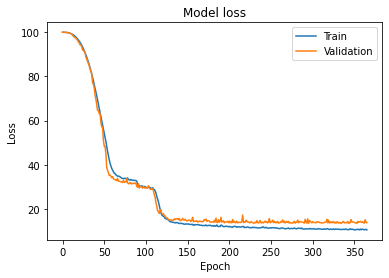

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Hit Rate :
* 命中率表示有多少比例的不動產估值誤差低於某一誤差水準值，命中率愈高代表模型表現愈好。

* 舉例說明，誤差在10%內的命中率為80%，代表在100筆資料中，有80筆資料估計的誤差範圍落在10%以內，剩餘的20筆資料是估計誤差大於10%。

* 實務研究中，誤差在10%的命中率為50%，而誤差在20%的命中率為80%才符合自動大量估價模型命中率的標準。

#### 定義函式: 計算出預測值落在誤差10%內之命中率

In [49]:
def hit_rate10(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    res = np.abs(y_true - y_pred)
    hit = []
    count = 0
    for i in res:
        if i < 0.1 * y_true[count]:
            hit.append(1)
        else:
            hit.append(0)
        count += 1
    return sum(hit)/len(y_true)*100

#### 定義函式: 計算出預測值落在誤差11%內之命中率

In [50]:
def hit_rate11(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    res = np.abs(y_true - y_pred)
    hit = []
    count = 0
    for i in res:
        if i < 0.11 * y_true[count]:
            hit.append(1)
        else:
            hit.append(0)
        count += 1
    return sum(hit)/len(y_true)*100

#### 定義函式: 計算出預測值落在誤差20%內之命中率

In [52]:
def hit_rate20(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    res = np.abs(y_true - y_pred)
    hit = []
    count = 0
    for i in res:
        if i < 0.2 * y_true[count]:
            hit.append(1)
        else:
            hit.append(0)
        count += 1
    return sum(hit)/len(y_true)*100

### 命中率結果

In [53]:
print(f"誤差在10%的命中率為: {hit_rate10(y_test,result)} %")
print(f"誤差在11%的命中率為: {hit_rate11(y_test,result)} %")
print(f"誤差在20%的命中率為: {hit_rate20(y_test,result)} %")

誤差在10%的命中率為: 47.91464597478176 %
誤差在11%的命中率為: 51.35790494665373 %
誤差在12%的命中率為: 54.31619786614937 %
誤差在20%的命中率為: 75.80019398642095 %


### 精度評估
* 由AVM模型得知，預測估計值在誤差11%內的命中率達51.35%，雖說已有一定成果，本研究之模型參數可能需再做調整。實務研究中符合自動大量估價模型命中率的標準為:誤差10%內的命中率達50%(本研究模型為47.9%)、誤差20%內的命中率達80%(本研究模型為75.8%)，可見本研究模型仍近乎達到自動大量估價模型命中率之標準。

## 未來展望

1. 資料樣本的多寡是影響的重要因素之一，由於必須考量地區、時間、離群子與房屋類型，所以我們刪除了大半筆資料，導致我們的訓練資料不足一萬筆，進而導致預測結果可能沒有達到最優解。所以我們以後若需要改良程式，蒐集筆數多且完善的資料是我們需要多下工夫的地方。

2. 本次報告透過房屋的特徵與價格來訓練資料，但買賣房屋還是有許多無法量化的因素，例如風水問題、該地區幾年前與幾年後的公設發展，甚至政治因素、物價因素、都市計畫等等，所以如果也能將這類影響資訊取得客觀量化基準，運用深度學習所建構的預測模型會更符合實際住房的買賣成交情形。

3. 本次模型未加入poi因子(位置變數)，可能是影響命中率大小的原因之一，未來將試著納入更多潛在影響不動產交易價格之變數，以及考慮時間因素(成交價格隨著市場行情而改變)，試著將訓練資料整理成時間序列型資料，在模型內先加入RNN(LSTM層)再加入全連結神經網路，藉以提高模型之命中率。
